<a href="https://colab.research.google.com/github/Prasad4587/DSBDL/blob/main/MiniprojectVIsem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔧 Best Parameters:
 {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88       102
           1       0.88      0.88      0.88       102

    accuracy                           0.88       204
   macro avg       0.88      0.88      0.88       204
weighted avg       0.88      0.88      0.88       204

🧾 Confusion Matrix:
 [[90 12]
 [12 90]]
✅ Accuracy: 0.8823529411764706


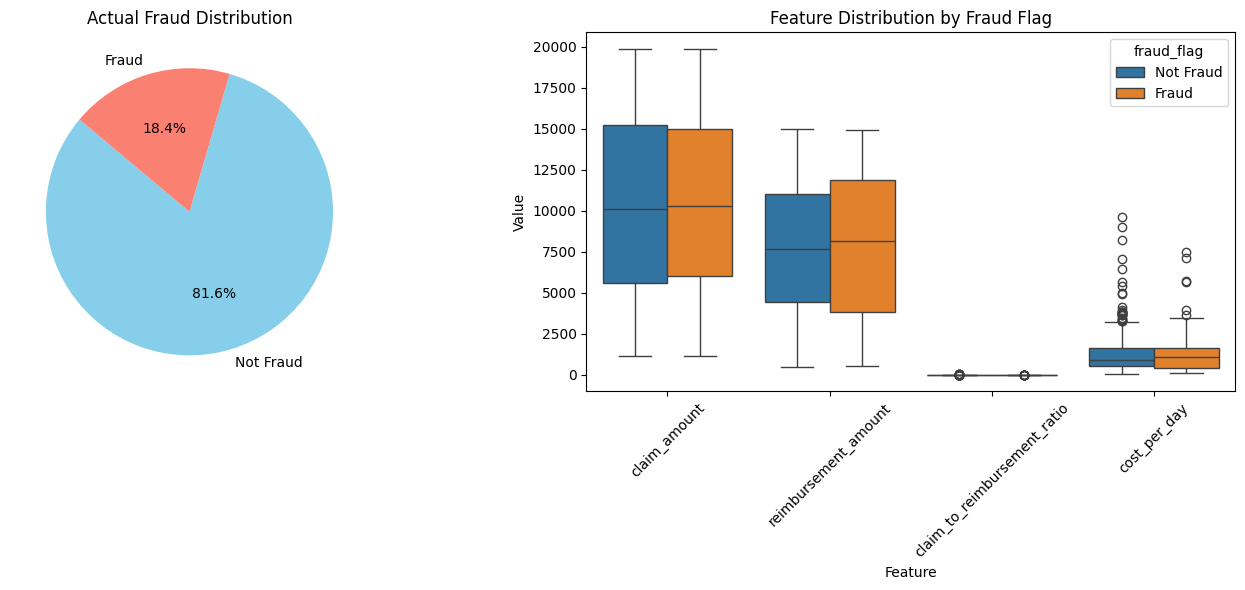

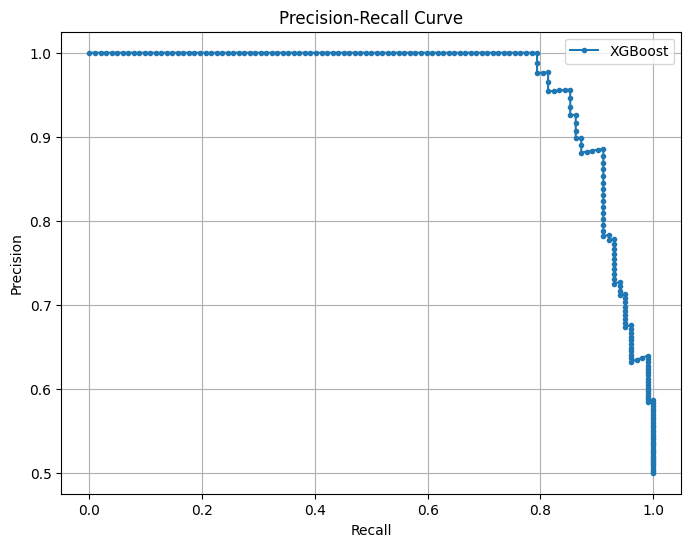

🔍 Average Precision Score: 0.964


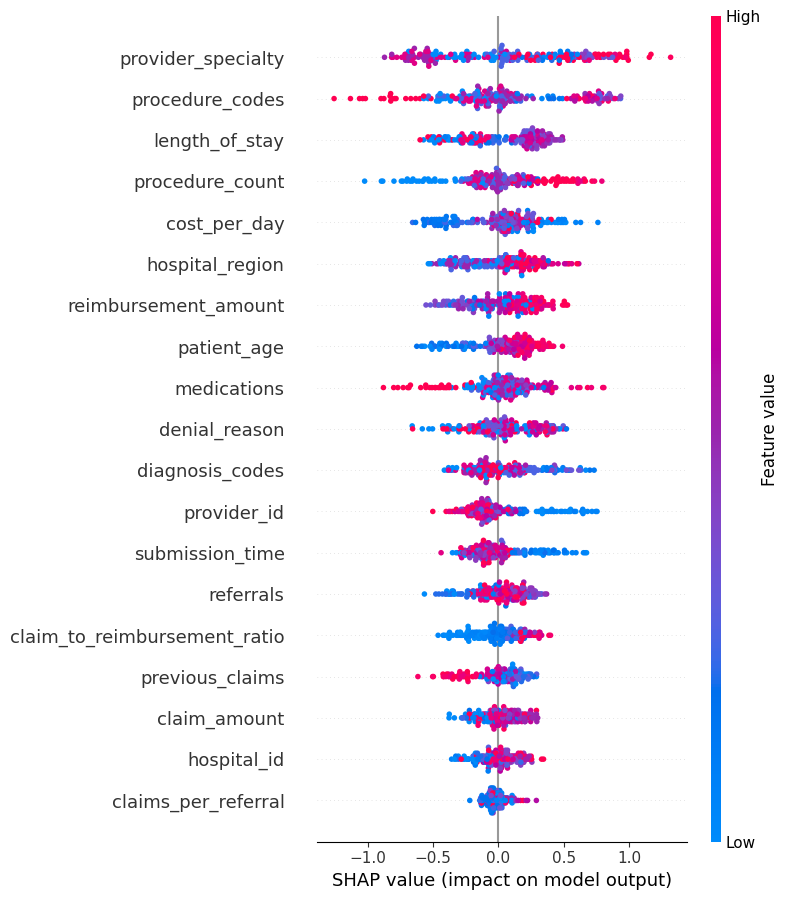

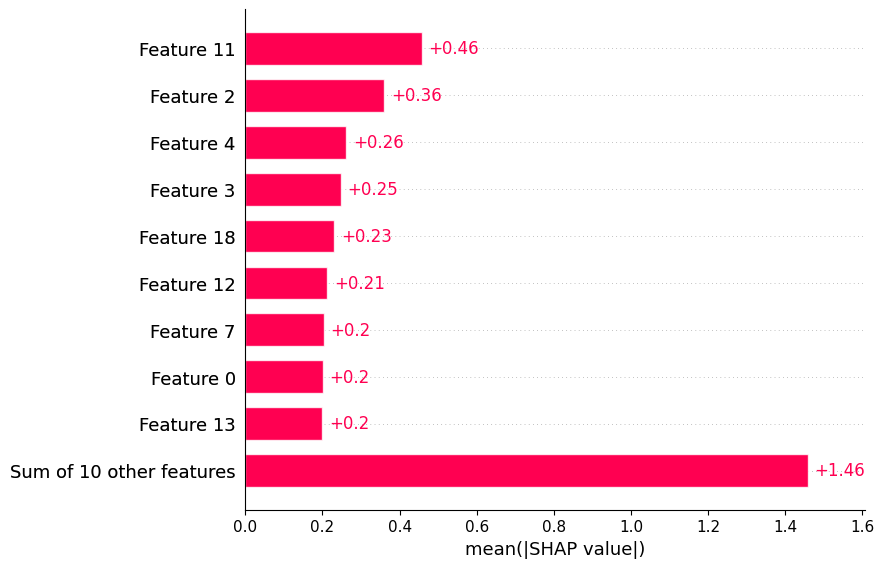

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
                                                                                                                                                                                                                              import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
)

from imblearn.over_sampling import SMOTE

# -----------------------------
# 1. Load the dataset
# -----------------------------
df = pd.read_excel("large_insurance_fraud_dataset.xlsx")

# -----------------------------
# 2. Preprocessing
# -----------------------------
categorical_cols = [
    "diagnosis_codes", "procedure_codes", "submission_time", "provider_id",
    "hospital_id", "provider_specialty", "hospital_region", "medications", "denial_reason"
]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # ensure all are string

df.drop("policy_id", axis=1, inplace=True)  # drop ID

# -----------------------------
# 3. Feature Engineering
# -----------------------------
df["claim_to_reimbursement_ratio"] = df["claim_amount"] / (df["reimbursement_amount"] + 1)
df["claims_per_referral"] = df["previous_claims"] / (df["referrals"] + 1)
df["cost_per_day"] = df["claim_amount"] / (df["length_of_stay"] + 1)

# -----------------------------
# 4. Define Features and Labels
# -----------------------------
X = df.drop("fraud_flag", axis=1)
y = df["fraud_flag"]

# -----------------------------
# 5. Scaling and SMOTE
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# -----------------------------
# 6. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, stratify=y_resampled, random_state=42
)

# -----------------------------
# 7. XGBoost + GridSearchCV
# -----------------------------
xgb_clf = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    reg_lambda=1,
    reg_alpha=0.5,
    scale_pos_weight=1,
    use_label_encoder=False
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# -----------------------------
# 8. Evaluation
# -----------------------------
print("🔧 Best Parameters:\n", grid_search.best_params_)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🧾 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# -----------------------------
# 9. Visualizations
# -----------------------------
plt.figure(figsize=(14, 6))

# Pie chart
plt.subplot(1, 2, 1)
fraud_counts = df["fraud_flag"].value_counts()
plt.pie(fraud_counts, labels=["Not Fraud", "Fraud"], autopct='%1.1f%%',
        startangle=140, colors=["skyblue", "salmon"])
plt.title("Actual Fraud Distribution")

# Boxplots
plt.subplot(1, 2, 2)
important_features = ["claim_amount", "reimbursement_amount",
                      "claim_to_reimbursement_ratio", "cost_per_day"]

df_viz = df[important_features + ["fraud_flag"]].copy()
df_viz["fraud_flag"] = df_viz["fraud_flag"].map({0: "Not Fraud", 1: "Fraud"})
df_melt = df_viz.melt(id_vars="fraud_flag", var_name="Feature", value_name="Value")

sns.boxplot(data=df_melt, x="Feature", y="Value", hue="fraud_flag")
plt.xticks(rotation=45)
plt.title("Feature Distribution by Fraud Flag")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

print(f"🔍 Average Precision Score: {average_precision_score(y_test, y_proba):.3f}")

# -----------------------------
# 10. SHAP Explainability
# -----------------------------
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)
shap.plots.bar(shap_values)

# Optional force plot for one sample
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=X.columns, matplotlib=True)